## Working with Different Types of Data

This chapter covers building expressions, which are the bread and butter of Spark’s structured operations. We also review working with a variety of different kinds of data, including the following:

* Booleans

* Numbers

* Strings

* Dates and timestamps

* Handling null

* Complex types

* User-defined functions

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Chapter 6").getOrCreate()

23/11/20 07:38:06 WARN Utils: Your hostname, FM-PC-LT-342 resolves to a loopback address: 127.0.1.1; using 192.168.1.75 instead (on interface wlp0s20f3)
23/11/20 07:38:06 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/20 07:38:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
spark

In [3]:
df = spark.read.option("inferSchema","true").option("header","true").csv("/home/fm-pc-lt-342/Documents/Spark Docx/datasets/datas/retail-data/2010-12-01.csv")
df.createOrReplaceTempView("dfTable")

In [4]:
df.show(3,truncate=False)

+---------+---------+----------------------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|Description                       |Quantity|InvoiceDate        |UnitPrice|CustomerID|Country       |
+---------+---------+----------------------------------+--------+-------------------+---------+----------+--------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER|6       |2010-12-01 08:26:00|2.55     |17850.0   |United Kingdom|
|536365   |71053    |WHITE METAL LANTERN               |6       |2010-12-01 08:26:00|3.39     |17850.0   |United Kingdom|
|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER    |8       |2010-12-01 08:26:00|2.75     |17850.0   |United Kingdom|
+---------+---------+----------------------------------+--------+-------------------+---------+----------+--------------+
only showing top 3 rows



### Working with Booleans


* Boolean statements consist of four elements: and, or, true, and false. We use these simple structures to build logical statements that evaluate to either true or false.
* We can specify Boolean expressions with multiple parts when you use **and** or **or** . 
* In spark we should always chain together **and** filters as a sequential filter. The reason for this is that even if Boolean statements are expressed serially (one after the other),Spark will flatten all of these filters into one statement and perform the filter at the same time, creating the and statement for us.
* **or** statements need to be specified in the same statement

In [5]:
from pyspark.sql.functions import col,instr
df.where(col("InvoiceNo")==536365).select("InvoiceNo","Description").show()

+---------+--------------------+
|InvoiceNo|         Description|
+---------+--------------------+
|   536365|WHITE HANGING HEA...|
|   536365| WHITE METAL LANTERN|
|   536365|CREAM CUPID HEART...|
|   536365|KNITTED UNION FLA...|
|   536365|RED WOOLLY HOTTIE...|
|   536365|SET 7 BABUSHKA NE...|
|   536365|GLASS STAR FROSTE...|
+---------+--------------------+



In [6]:
priceFilter = col("UnitPrice")>600
descripFilter = instr(df.Description,"POSTAGE") >=1
df.where(df.StockCode.isin("DOT")).where(priceFilter | descripFilter).show()

+---------+---------+--------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|   Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------+--------+-------------------+---------+----------+--------------+
|   536544|      DOT|DOTCOM POSTAGE|       1|2010-12-01 14:32:00|   569.77|      null|United Kingdom|
|   536592|      DOT|DOTCOM POSTAGE|       1|2010-12-01 17:06:00|   607.49|      null|United Kingdom|
+---------+---------+--------------+--------+-------------------+---------+----------+--------------+



In [7]:
priceFilter = col("UnitPrice")>600
descripFilter = instr(col("Description"),"POSTAGE") >=1
df.where(df.StockCode.isin("DOT")).where(priceFilter | descripFilter).show()

+---------+---------+--------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|   Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------+--------+-------------------+---------+----------+--------------+
|   536544|      DOT|DOTCOM POSTAGE|       1|2010-12-01 14:32:00|   569.77|      null|United Kingdom|
|   536592|      DOT|DOTCOM POSTAGE|       1|2010-12-01 17:06:00|   607.49|      null|United Kingdom|
+---------+---------+--------------+--------+-------------------+---------+----------+--------------+



In [8]:
spark.sql("""SELECT UnitPrice, (StockCode = 'DOT' AND
(UnitPrice > 600 OR instr(Description, "POSTAGE") >= 1)) as isExpensive
FROM dfTable
WHERE (StockCode = 'DOT' AND
(UnitPrice > 600 OR instr(Description, "POSTAGE") >= 1))""").show()

+---------+-----------+
|UnitPrice|isExpensive|
+---------+-----------+
|   569.77|       true|
|   607.49|       true|
+---------+-----------+



### Boolean expressions are not just reserved to filters. To filter a DataFrame, you can also just specify a Boolean column:

In [9]:
DOTCodeFilter = col("StockCode") == "DOT"
priceFilter = col("UnitPrice") > 600
descripFilter = instr(col("Description"), "POSTAGE") >= 1
df.withColumn("isExpensive",DOTCodeFilter & (priceFilter | descripFilter)).where("isExpensive").select("unitPrice", "isExpensive").show(5)

+---------+-----------+
|unitPrice|isExpensive|
+---------+-----------+
|   569.77|       true|
|   607.49|       true|
+---------+-----------+



### Working with Numbers
To fabricate a contrived example, let’s imagine that we found out that we mis-recorded the quantity in our retail dataset and the true quantity is equal to (the current quantity * the unit
price)2 + 5. This will introduce our first numerical function as well as the pow function that raises a column to the expressed power:

In [10]:
from pyspark.sql.functions import expr, pow,lit,bround,round
fabricatedQuantity = pow(col("Quantity")* col("UnitPrice"),2) + 5
df.select(expr("CustomerId"),fabricatedQuantity.alias("realQuantity")).show(2)

+----------+------------------+
|CustomerId|      realQuantity|
+----------+------------------+
|   17850.0|239.08999999999997|
|   17850.0|          418.7156|
+----------+------------------+
only showing top 2 rows



In [11]:
df.selectExpr(
"CustomerId",
"(POWER((Quantity * UnitPrice), 2.0) + 5) as realQuantity").show(2)

+----------+------------------+
|CustomerId|      realQuantity|
+----------+------------------+
|   17850.0|239.08999999999997|
|   17850.0|          418.7156|
+----------+------------------+
only showing top 2 rows



In [12]:
df.select(round(lit(2.5)),bround(lit(2.5))).show(2)

+-------------+--------------+
|round(2.5, 0)|bround(2.5, 0)|
+-------------+--------------+
|          3.0|           2.0|
|          3.0|           2.0|
+-------------+--------------+
only showing top 2 rows



### Correlation
Another numerical task is to compute the correlation of two columns. For example, we can see
the Pearson correlation coefficient for two columns to see if cheaper things are typically bought
in greater quantities. We can do this through a function as well as through the DataFrame
statistic methods:

In [13]:
from pyspark.sql.functions import corr
# df.stat.corr("Quantity","UnitPrice")
df.select(corr("Quantity","UnitPrice")).show()
'''-- in SQL
SELECT corr(Quantity, UnitPrice) FROM dfTable'''

+-------------------------+
|corr(Quantity, UnitPrice)|
+-------------------------+
|     -0.04112314436835551|
+-------------------------+



'-- in SQL\nSELECT corr(Quantity, UnitPrice) FROM dfTable'

In [14]:
df.describe().show()

23/11/20 08:05:13 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-----------------+------------------+--------------------+------------------+------------------+------------------+--------------+
|summary|        InvoiceNo|         StockCode|         Description|          Quantity|         UnitPrice|        CustomerID|       Country|
+-------+-----------------+------------------+--------------------+------------------+------------------+------------------+--------------+
|  count|             3108|              3108|                3098|              3108|              3108|              1968|          3108|
|   mean| 536516.684944841|27834.304044117645|                null| 8.627413127413128| 4.151946589446603|15661.388719512195|          null|
| stddev|72.89447869788873|17407.897548583845|                null|26.371821677029203|15.638659854603892|1854.4496996893627|          null|
|    min|           536365|             10002| 4 PURPLE FLOCK D...|               -24|               0.0|           12431.0|     Australia|
|    max|          C

### Working with Strings

String manipulation shows up in nearly every data flow, and it’s worth explaining what you can do with strings. You might be manipulating log files performing regular expression extraction or
substitution, or checking for simple string existence, or making all strings uppercase or lowercase.

Let’s begin with the last task because it’s the most straightforward. The initcap function will
capitalize every word in a given string when that word is separated from another by a space.

In [15]:
from pyspark.sql.functions import initcap
df.select(initcap(col("Description"))).show(3)

+--------------------+
|initcap(Description)|
+--------------------+
|White Hanging Hea...|
| White Metal Lantern|
|Cream Cupid Heart...|
+--------------------+
only showing top 3 rows



In [16]:
### Uppercase and LowerCase
from pyspark.sql.functions import lower,upper
df.select(upper(col("Description")).alias("Description_Upper"),lower("Description").alias("Description_Lower")).show(3)

+--------------------+--------------------+
|   Description_Upper|   Description_Lower|
+--------------------+--------------------+
|WHITE HANGING HEA...|white hanging hea...|
| WHITE METAL LANTERN| white metal lantern|
|CREAM CUPID HEART...|cream cupid heart...|
+--------------------+--------------------+
only showing top 3 rows



In [17]:
### Trimming White Spaces
'''ltrim: to trim white space in left
   rtrim to trim white space in right
   trim to trim white spaces in both sides
'''
from pyspark.sql.functions import lit, ltrim, rtrim, rpad, lpad, trim

df.select(ltrim(lit("     HELLO   ")).alias("ltrim"),
 rtrim(lit("    HELLO     ")).alias("rtrim"),
 trim(lit("  HELLO    ")).alias("trim"),
lpad(lit("HELLO "), 10, "---").alias("lp"),
rpad(lit("HELLO"), 10, " ").alias("rp")).show(2)

+--------+---------+-----+----------+----------+
|   ltrim|    rtrim| trim|        lp|        rp|
+--------+---------+-----+----------+----------+
|HELLO   |    HELLO|HELLO|----HELLO |HELLO     |
|HELLO   |    HELLO|HELLO|----HELLO |HELLO     |
+--------+---------+-----+----------+----------+
only showing top 2 rows



### Regular Expressions

Probably one of the most frequently performed tasks is searching for the existence of one string in another or replacing all mentions of a string with another value. This is often done with a tool
called regular expressions that exists in many programming languages. Regular expressions give the user an ability to specify a set of rules to use to either extract values from a string or replace
them with some other values.

Spark takes advantage of the complete power of Java regular expressions. The Java regular expression syntax departs slightly from other programming languages, so it is worth reviewing before putting anything into production.

There are two key functions in Spark that you’ll need in order to perform regular expression tasks: regexp_extract and regexp_replace. These
functions extract values and replace values, respectively.

In [18]:
from pyspark.sql.functions import regexp_extract, regexp_replace

regex_string = "BLACK|WHITE|RED|GREEN|BLUE"
df.select(regexp_replace(col("Description"),regex_string,"COLOR").alias("color_clean"),col("Description")).show(5)

+--------------------+--------------------+
|         color_clean|         Description|
+--------------------+--------------------+
|COLOR HANGING HEA...|WHITE HANGING HEA...|
| COLOR METAL LANTERN| WHITE METAL LANTERN|
|CREAM CUPID HEART...|CREAM CUPID HEART...|
|KNITTED UNION FLA...|KNITTED UNION FLA...|
|COLOR WOOLLY HOTT...|RED WOOLLY HOTTIE...|
+--------------------+--------------------+
only showing top 5 rows



Another task might be to replace given characters with other characters. Building this as a
regular expression could be tedious, so Spark also provides the translate function to replace these
values. This is done at the character level and will replace all instances of a character with the
indexed character in the replacement string:

In [19]:
from pyspark.sql.functions import translate
df.select(translate(col("Description"),"LEET","1337"),col("Description")).show(3)

+----------------------------------+--------------------+
|translate(Description, LEET, 1337)|         Description|
+----------------------------------+--------------------+
|              WHI73 HANGING H3A...|WHITE HANGING HEA...|
|               WHI73 M37A1 1AN73RN| WHITE METAL LANTERN|
|              CR3AM CUPID H3AR7...|CREAM CUPID HEART...|
+----------------------------------+--------------------+
only showing top 3 rows



We can also perform something similar, like pulling out the first mentioned color:

In [20]:
from pyspark.sql.functions import regexp_extract
extract_str = "(BLACK|WHITE|RED|GREEN|BLUE)"
df.select(regexp_extract(col("Description"),extract_str,1).alias("extracted_string"),col("Description")).show(3)

+----------------+--------------------+
|extracted_string|         Description|
+----------------+--------------------+
|           WHITE|WHITE HANGING HEA...|
|           WHITE| WHITE METAL LANTERN|
|                |CREAM CUPID HEART...|
+----------------+--------------------+
only showing top 3 rows



### Working with Dates and Timestamps

Dates and times are a constant challenge in programming languages and databases. It’s always
necessary to keep track of timezones and ensure that formats are correct and valid. Spark does its
best to keep things simple by focusing explicitly on two kinds of time-related information. There
are dates, which focus exclusively on calendar dates, and timestamps, which include both date
and time information.

In [21]:
df.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: double (nullable = true)
 |-- Country: string (nullable = true)



In [22]:
from pyspark.sql.functions import current_date, current_timestamp

dateDF = spark.range(10).\
    withColumn("today", current_date()).\
    withColumn("now", current_timestamp())
dateDF.createOrReplaceTempView("dateTable")

In [23]:
dateDF.show(truncate=False)

+---+----------+--------------------------+
|id |today     |now                       |
+---+----------+--------------------------+
|0  |2023-11-20|2023-11-20 08:08:34.064544|
|1  |2023-11-20|2023-11-20 08:08:34.064544|
|2  |2023-11-20|2023-11-20 08:08:34.064544|
|3  |2023-11-20|2023-11-20 08:08:34.064544|
|4  |2023-11-20|2023-11-20 08:08:34.064544|
|5  |2023-11-20|2023-11-20 08:08:34.064544|
|6  |2023-11-20|2023-11-20 08:08:34.064544|
|7  |2023-11-20|2023-11-20 08:08:34.064544|
|8  |2023-11-20|2023-11-20 08:08:34.064544|
|9  |2023-11-20|2023-11-20 08:08:34.064544|
+---+----------+--------------------------+



Now that we have a simple DataFrame to work with, let’s add and subtract five days from today.
These functions take a column and then the number of days to either add or subtract as the
arguments:

In [25]:
from pyspark.sql.functions import date_add,date_sub

# dateDF.select(date_sub("today",5),date_add("today",5)).show(3)
dateDF.select(date_sub("today",5), date_add("today",5)).show(3)

+------------------+------------------+
|date_sub(today, 5)|date_add(today, 5)|
+------------------+------------------+
|        2023-11-15|        2023-11-25|
|        2023-11-15|        2023-11-25|
|        2023-11-15|        2023-11-25|
+------------------+------------------+
only showing top 3 rows



In [26]:
from pyspark.sql.functions import datediff, months_between, to_date
dateDF.withColumn("week_ago", date_sub(col("today"), 7))\
.select(datediff(col("today"),col("week_ago"),)).show(1)

+-------------------------+
|datediff(today, week_ago)|
+-------------------------+
|                        7|
+-------------------------+
only showing top 1 row



In [27]:
'''The to_date function allows
you to convert a string to a date, optionally with a specified format'''

dateDF.select(
to_date(lit("2016-01-01")).alias("start"),
to_date(lit("2017-05-22")).alias("end"))\
.select(months_between(col("start"), col("end"))).show(1)

+--------------------------------+
|months_between(start, end, true)|
+--------------------------------+
|                    -16.67741935|
+--------------------------------+
only showing top 1 row



In [28]:
from pyspark.sql.functions import to_date
dateFormat = "yyyy-dd-MM"
cleanDateDF = spark.range(1).select(
to_date(lit("2017-12-11"), dateFormat).alias("date"),
to_date(lit("2017-20-12"), dateFormat).alias("date2"))
cleanDateDF.createOrReplaceTempView("dateTable2")
cleanDateDF.show()



+----------+----------+
|      date|     date2|
+----------+----------+
|2017-11-12|2017-12-20|
+----------+----------+



In [29]:
from pyspark.sql.functions import to_timestamp
cleanDateDF.select(to_timestamp(col("date"), dateFormat)).show()

+------------------------------+
|to_timestamp(date, yyyy-dd-MM)|
+------------------------------+
|           2017-11-12 00:00:00|
+------------------------------+



### Working with Nulls in Data

As a best practice, you should always use nulls to represent missing or empty data in your
DataFrames. Spark can optimize working with null values more than it can if you use empty
strings or other values. The primary way of interacting with null values, at DataFrame scale, is to 
use the .na subpackage on a DataFrame.

The simplest function is drop, which removes rows that contain nulls. The default is to drop any row in which any value is null:
* df.na.drop() / df.na.drop("any") - drops a row if any of the values are null.
* df.na.drop("all") - drops the row only if all values are null or NaN for that row

In [30]:
df.na.drop()
df.na.drop("any")   #Default any

DataFrame[InvoiceNo: string, StockCode: string, Description: string, Quantity: int, InvoiceDate: timestamp, UnitPrice: double, CustomerID: double, Country: string]

 Specifying "any" as an argument drops a row if any of the values are null. Using “all” drops the
row only if all values are null or NaN for that row:

In [32]:
df.na.drop("all")

DataFrame[InvoiceNo: string, StockCode: string, Description: string, Quantity: int, InvoiceDate: timestamp, UnitPrice: double, CustomerID: double, Country: string]

We can also apply this to certain sets of columns by passing in an array of columns:

In [33]:
df.na.drop("all",subset=["StockCode","InvoiceNo"])

DataFrame[InvoiceNo: string, StockCode: string, Description: string, Quantity: int, InvoiceDate: timestamp, UnitPrice: double, CustomerID: double, Country: string]

### fill na

Using the fill function, you can fill one or more columns with a set of values. This can be done
by specifying a map—that is a particular value and a set of columns.
For example, to fill all null values in columns of type String, you might specify the following:

In [34]:
df.na.fill("All null values become this string")

DataFrame[InvoiceNo: string, StockCode: string, Description: string, Quantity: int, InvoiceDate: timestamp, UnitPrice: double, CustomerID: double, Country: string]

In [35]:
# in Python
fill_cols_vals = {"StockCode": 5, "Description" : "No Value"}
df.na.fill(fill_cols_vals)

DataFrame[InvoiceNo: string, StockCode: string, Description: string, Quantity: int, InvoiceDate: timestamp, UnitPrice: double, CustomerID: double, Country: string]

### Working with Complex Types

Complex types can help you organize and structure your data in ways that make more sense for the problem that you are hoping to solve. There are three kinds of complex types: structs, arrays and maps.

### Struct

You can think of structs as DataFrames within DataFrames. A worked example will illustrate this more clearly. We can create a struct by wrapping a set of columns in parenthesis in a query:

In [36]:
from pyspark.sql.functions import struct
complexDF = df.select(struct("Description", "InvoiceNo").alias("complex"))
complexDF.createOrReplaceTempView("complexDF")
complexDF.show(truncate=False)

+---------------------------------------------+
|complex                                      |
+---------------------------------------------+
|{WHITE HANGING HEART T-LIGHT HOLDER, 536365} |
|{WHITE METAL LANTERN, 536365}                |
|{CREAM CUPID HEARTS COAT HANGER, 536365}     |
|{KNITTED UNION FLAG HOT WATER BOTTLE, 536365}|
|{RED WOOLLY HOTTIE WHITE HEART., 536365}     |
|{SET 7 BABUSHKA NESTING BOXES, 536365}       |
|{GLASS STAR FROSTED T-LIGHT HOLDER, 536365}  |
|{HAND WARMER UNION JACK, 536366}             |
|{HAND WARMER RED POLKA DOT, 536366}          |
|{ASSORTED COLOUR BIRD ORNAMENT, 536367}      |
|{POPPY'S PLAYHOUSE BEDROOM , 536367}         |
|{POPPY'S PLAYHOUSE KITCHEN, 536367}          |
|{FELTCRAFT PRINCESS CHARLOTTE DOLL, 536367}  |
|{IVORY KNITTED MUG COSY , 536367}            |
|{BOX OF 6 ASSORTED COLOUR TEASPOONS, 536367} |
|{BOX OF VINTAGE JIGSAW BLOCKS , 536367}      |
|{BOX OF VINTAGE ALPHABET BLOCKS, 536367}     |
|{HOME BUILDING BLOCK WORD, 536367}     

In [37]:
complexDF.printSchema()

root
 |-- complex: struct (nullable = false)
 |    |-- Description: string (nullable = true)
 |    |-- InvoiceNo: string (nullable = true)



We now have a DataFrame with a column complex. We can query it just as we might another DataFrame, the only difference is that we use a dot syntax to do so, or the column method getField:

In [38]:
complexDF.select("complex.Description").show(3,truncate=False)

+----------------------------------+
|Description                       |
+----------------------------------+
|WHITE HANGING HEART T-LIGHT HOLDER|
|WHITE METAL LANTERN               |
|CREAM CUPID HEARTS COAT HANGER    |
+----------------------------------+
only showing top 3 rows



In [39]:
complexDF.select(col("complex").getField("Description"),col("complex").getField("InvoiceNo")).show(3,truncate=False)

+----------------------------------+-----------------+
|complex.Description               |complex.InvoiceNo|
+----------------------------------+-----------------+
|WHITE HANGING HEART T-LIGHT HOLDER|536365           |
|WHITE METAL LANTERN               |536365           |
|CREAM CUPID HEARTS COAT HANGER    |536365           |
+----------------------------------+-----------------+
only showing top 3 rows



### Arrays

To define arrays, let’s work through a use case. With our current data, our objective is to take
every single word in our Description column and convert that into a row in our DataFrame.
The first task is to turn our Description column into a complex type, an array.

### Split

In [40]:
from pyspark.sql.functions import split
df.select(split(col("Description"),' ')).show(3,truncate=False)

+----------------------------------------+
|split(Description,  , -1)               |
+----------------------------------------+
|[WHITE, HANGING, HEART, T-LIGHT, HOLDER]|
|[WHITE, METAL, LANTERN]                 |
|[CREAM, CUPID, HEARTS, COAT, HANGER]    |
+----------------------------------------+
only showing top 3 rows



This is quite powerful because Spark allows us to manipulate this complex type as another column. We can also query the values of the array using Python-like syntax:

In [41]:
df.select(split(col("Description"), " ").alias("array_col")).selectExpr("array_col[0]").show(3)

+------------+
|array_col[0]|
+------------+
|       WHITE|
|       WHITE|
|       CREAM|
+------------+
only showing top 3 rows



### array_contains

In [42]:
from pyspark.sql.functions import array_contains
df.select(array_contains(split(col("Description"), " "), "WHITE")).show(5)

+------------------------------------------------+
|array_contains(split(Description,  , -1), WHITE)|
+------------------------------------------------+
|                                            true|
|                                            true|
|                                           false|
|                                           false|
|                                            true|
+------------------------------------------------+
only showing top 5 rows



### explode
The explode function takes a column that consists of arrays and creates one row (with the rest of
the values duplicated) per value in the array. Figure 6-1 illustrates the process.

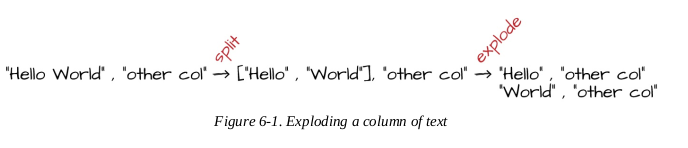

In [43]:
from pyspark.sql.functions import  explode
df.withColumn("splitted", split(col("Description"), " ")).withColumn("exploded", explode(col("splitted")))\
.select("Description", "InvoiceNo", "exploded").show(3,truncate=False)

+----------------------------------+---------+--------+
|Description                       |InvoiceNo|exploded|
+----------------------------------+---------+--------+
|WHITE HANGING HEART T-LIGHT HOLDER|536365   |WHITE   |
|WHITE HANGING HEART T-LIGHT HOLDER|536365   |HANGING |
|WHITE HANGING HEART T-LIGHT HOLDER|536365   |HEART   |
+----------------------------------+---------+--------+
only showing top 3 rows



In [69]:
from pyspark.sql.functions import coalesce
df.select(coalesce(col("Description"), col("CustomerId"))).show(truncate=False)

+-----------------------------------+
|coalesce(Description, CustomerId)  |
+-----------------------------------+
|WHITE HANGING HEART T-LIGHT HOLDER |
|WHITE METAL LANTERN                |
|CREAM CUPID HEARTS COAT HANGER     |
|KNITTED UNION FLAG HOT WATER BOTTLE|
|RED WOOLLY HOTTIE WHITE HEART.     |
|SET 7 BABUSHKA NESTING BOXES       |
|GLASS STAR FROSTED T-LIGHT HOLDER  |
|HAND WARMER UNION JACK             |
|HAND WARMER RED POLKA DOT          |
|ASSORTED COLOUR BIRD ORNAMENT      |
|POPPY'S PLAYHOUSE BEDROOM          |
|POPPY'S PLAYHOUSE KITCHEN          |
|FELTCRAFT PRINCESS CHARLOTTE DOLL  |
|IVORY KNITTED MUG COSY             |
|BOX OF 6 ASSORTED COLOUR TEASPOONS |
|BOX OF VINTAGE JIGSAW BLOCKS       |
|BOX OF VINTAGE ALPHABET BLOCKS     |
|HOME BUILDING BLOCK WORD           |
|LOVE BUILDING BLOCK WORD           |
|RECIPE BOX WITH METAL HEART        |
+-----------------------------------+
only showing top 20 rows



### Maps 
Maps are created by using the map function and key-value pairs of columns. You then can select
them just like you might select from an array:

In [74]:
# in Python
from pyspark.sql.functions import create_map
df.select(create_map(col("Description"), col("InvoiceNo")).alias("complex_map"))\
.show(2,truncate=False)

+----------------------------------------------+
|complex_map                                   |
+----------------------------------------------+
|{WHITE HANGING HEART T-LIGHT HOLDER -> 536365}|
|{WHITE METAL LANTERN -> 536365}               |
+----------------------------------------------+
only showing top 2 rows



### Working with JSON
Spark has some unique support for working with JSON data. You can directly operate on strings of JSON in Spark and parse from JSON or extract JSON objects. Let's begin by creating a JSON column:

In [44]:
jsonDF = spark.range(1).selectExpr("""'{"myJSONKey" : {"myJSONValue" : [1, 2, 3]}}' as jsonString""")

In [47]:
from pyspark.sql.functions import get_json_object, json_tuple

jsonDF.select(get_json_object(col("jsonString"), "$.myJSONKey.myJSONValue[1]") )as "column",json_tuple(col("jsonString"), "myJSONKey")).show(2)

jsonDF.select(get_json_object(col("jsonString"), "$.myJSONKey.myJSONValue[1]") as "column",json_tuple(col("jsonString"), "myJSONKey")
).show(2)


SyntaxError: invalid syntax (1936069557.py, line 5)

### User-Defined Functions

One of the most powerful things that you can do in Spark is define your own functions. These user-defined functions (UDFs) make it possible for you to write your own custom transformations using Python or Scala and even use external libraries.UDFs can take and return one or more columns as input. Spark UDFs are incredibly powerful because you can write them
in several different programming languages; you do not need to create them in an esoteric format
or domain-specific language. They’re just functions that operate on the data, record by record.
By default, these functions are registered as temporary functions to be used in that specific
SparkSession or Context.

In [48]:
from pyspark.sql.functions import udf

#making df of range 5 with columnname num
udfExampleDF = spark.range(5).toDF("num")

#creating function that returns power of 3
def power3(double_value):
    return double_value ** 3

#register the udf
powerudf = udf(power3)

#use udf to apply transformation on dataframe
udfExampleDF.select(powerudf(col("num"))).show()

+-----------+
|power3(num)|
+-----------+
|          0|
|          1|
|          8|
|         27|
|         64|
+-----------+

